In [7]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma
import time
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import scipy.stats as stats

In [8]:
#### first part ####
from scipy.stats import ortho_group

def generate_ISA(n,d,sigma_normal,alpha):
    
    x = np.concatenate((np.random.normal(-1, sigma_normal, n//2), np.random.normal(1, sigma_normal, n//2)))
    y = np.concatenate((np.random.normal(-1, sigma_normal, n//2), np.random.normal(1, sigma_normal, n//2)))
    p = np.random.permutation(n)
    y_p = y[p]

    D = np.zeros([2,n])
    D[0,:] = x
    D[1,:] = y_p

    theta = np.pi/4*alpha
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    D_R = R@D
    X_mix = D_R[0,:].reshape(-1,1)
    Y_mix = D_R[1,:].reshape(-1,1)

    X_z = np.random.randn(n,d-1)
    Y_z = np.random.randn(n,d-1)

    X_con = np.concatenate((X_mix,X_z), axis=1)
    Y_con = np.concatenate((Y_mix,Y_z), axis=1)

    m_x = ortho_group.rvs(dim=d)
    m_y = ortho_group.rvs(dim=d)

    X = (m_x@X_con.T).T
    Y = (m_y@Y_con.T).T
    
    return X,Y

In [9]:
def rbf_kernel(pattern1, pattern2, kernel_width):
    size1 = pattern1.size()
    size2 = pattern2.size()

    G = torch.sum(pattern1*pattern1, 1).reshape(size1[0],1)
    H = torch.sum(pattern2*pattern2, 1).reshape(size2[0],1)

    Q = torch.tile(G, (1, size2[0]))
    R = torch.tile(H.T, (size1[0], 1))

    H = Q + R - 2* (pattern1@pattern2.T)
    H = torch.exp(-H/2/(kernel_width**2))

    return H

def kernel_midwidth_rbf(X,Y):
    
    n = len(X)
    # ----- width of X -----
    Xmed = X

    G = torch.sum(Xmed*Xmed, 1).reshape(n,1)
    Q = torch.tile(G, (1, n) )
    R = torch.tile(G.T, (n, 1) )

    dists = Q + R - 2* (Xmed@Xmed.T)
    dists = dists - torch.tril(dists)
    dists = dists.reshape(n**2, 1)

    width_x = torch.sqrt( 0.5 * torch.median(dists[dists>0]))

    # ----- width of Y -----
    Ymed = Y

    G = torch.sum(Ymed*Ymed, 1).reshape(n,1)
    Q = torch.tile(G, (1, n) )
    R = torch.tile(G.T, (n, 1) )

    dists = Q + R - 2* (Ymed@Ymed.T)
    dists = dists - torch.tril(dists)
    dists = dists.reshape(n**2, 1)

    width_y = torch.sqrt( 0.5 * torch.median(dists[dists>0]))
    
    return width_x, width_y


def cal_thresh(K,L,Kcc,Lcc,confident_level = 0.05):
    
    n = len(K)
    
    varHSIC = (Kcc * Lcc / 6)**2
    varHSIC = (torch.sum(varHSIC) - torch.trace(varHSIC)) / n / (n-1)
    varHSIC = varHSIC * 72 * (n-4) * (n-5) / n / (n-1) / (n-2) / (n-3)

    K = K - torch.diag(torch.diag(K))
    L = L - torch.diag(torch.diag(L))

    muX = torch.sum(K) / n / (n-1)
    muY = torch.sum(L) / n / (n-1)

    mHSIC = (1 + muX * muY - muX - muY) / n

    al = (mHSIC**2 / varHSIC).detach().numpy()
    bet = (varHSIC*n / mHSIC).detach().numpy()
    
    thresh = gamma.ppf(1-confident_level, al, scale=bet)
    
    return thresh, al, bet


def J_maxpower_term(K,L,Kc,Lc,lamb_reg = 1e-10):
    n = len(K)
    
    S = 0
    for i in range(n):
        S += torch.dot(Kc[i,:],Lc[:,i])

    testStat = S / n

    A = torch.sum(K*L,0).reshape(-1,1)
    B = torch.sum(K,1).reshape(-1,1)
    C = torch.sum(L,1).reshape(-1,1)
    D = B*C
    h_i = 1/2*((n**2)*A+n*torch.sum(A)+torch.sum(C)*B+torch.sum(B)*C-n*(D+K@C+L@B)-torch.sum(D))/(n**3)

    var_estimate = 16*(torch.sum((h_i)**2)/n-((testStat)/n)**2)
    var_estimate_reg = var_estimate+lamb_reg
    
    sigma_estimate_reg = torch.sqrt(var_estimate_reg)

    return testStat, sigma_estimate_reg

In [10]:
n = 250
R1 = []
wx_list = np.linspace(0.05,2,50)
d = 3
sigma_normal = 0.1
alpha = 0.4
X, Y = generate_ISA(n,d,sigma_normal,alpha)
X = torch.tensor(X)
Y = torch.tensor(Y)

# X = (X-torch.mean(X))/torch.std(X)
# Y = (Y-torch.mean(Y))/torch.std(Y)

confident = 0.05

for wx in wx_list:

    wy = 1.0
    K = rbf_kernel(X, X, wx)
    L = rbf_kernel(Y, Y, wy)

    Kc = K - torch.mean(K,0)
    Lc = L - torch.mean(L,0)
    
    sta, sigma = J_maxpower_term(K,L,Kc,Lc,lamb_reg = 1e-10)
    
    Kr = K - torch.mean(K,0)
    Lr = L - torch.mean(L,0)

    Kcc = Kr - torch.mean(Kr,1).reshape(-1,1)
    Lcc = Lr - torch.mean(Lr,1).reshape(-1,1)
    
    thresh, al, bet = cal_thresh(K,L,Kcc,Lcc, confident_level = confident)
    R1.append([sta/sigma, (sta-thresh)/sigma])

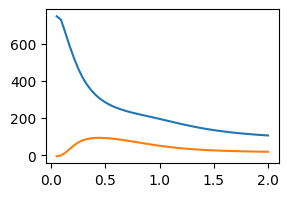

In [11]:
re = np.array(R1)

plt.figure(figsize=(3,2))
plt.plot(wx_list, re[:,-2])
plt.plot(wx_list, re[:,-1])